# Summarize Data

The `features` module packs a set of data summarization tools to calculate total counts, lengths, areas, and basic descriptive statistics of features and their attributes within areas or near other features. You can access these tools using the `summarize_data` sub module.

## Aggregate points
In this example, let us observe how to use `aggregate_points` tool to summarize data from spot measurements by area. To learn more about this tool and the formula it uses, refer to the documentation [here](http://doc.arcgis.com/en/arcgis-online/use-maps/aggregate-points.htm)

In [8]:
# connect to GIS
from arcgis.gis import GIS
gis = GIS("portal url", "username", "password")

<Item title:"earthquakes_2" type:Feature Layer Collection owner:arcgis_python>
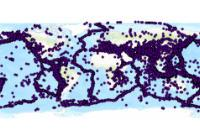

In [16]:
#search for earthquakes data - point data
eq_search = gis.content.search("world earthquakes locations", "feature layer", max_items=1)
eq_item = eq_search[0]
eq_item

In [15]:
# search for USA states - area / polygon data
states_search = gis.content.search("title:'USA States'", 
                                   "feature layer", max_items=1)
states_item = states_search[0]
states_item

Lets draw the layers on a map and observe how they are distributed

In [ ]:
map1 = gis.map("USA")
map1

![earthquakes and states](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_features_summarize_aggregate_points_01.PNG)

In [18]:
map1.add_layer(states_item)

In [19]:
map1.add_layer(eq_item)

### Aggregate earthquakes by state
As you can see, a number of earthquakes fall on the boundary of tectonic plates ([ring of fire](https://en.wikipedia.org/wiki/Ring_of_Fire)). However, there are a few more dispersed into other states. It would be interesting to aggregate all the earthquakes by state and plot that as a chart. 

The `aggregate_points` tool in the `summarize_data` sub module is a valid candidate for such analyses. The example below shows how to run this tool using ArcGIS API for Python.

To start with, let us access the layers in the states and earthquakes items and view their attribute information to understand how the data can be summarized

In [20]:
eq_fl = eq_item.layers[0]
states_fl = states_item.layers[0]

We have accessed the layers in the items as `FeatureLayer` objects. We can query the `fields` property to understand what kind of attribute data is stored in the layers

In [21]:
#query the fields in eq_fl layer
for field in eq_fl.properties.fields:
    print(field['name'])

objectid
datetime
latitude
longitude
depth
magnitude
magtype
nbstations
gap
distance
rms
source
eventid
occurrence_time


In [22]:
# similarly for states data
for field in states_fl.properties.fields:
    print(field['name'], end="\t")

FID	STATE_NAME	STATE_FIPS	SUB_REGION	STATE_ABBR	POPULATION	POP_SQMI	POP2010	POP10_SQMI	WHITE	BLACK	AMERI_ES	ASIAN	HAWN_PI	HISPANIC	OTHER	MULT_RACE	MALES	FEMALES	AGE_UNDER5	AGE_5_9	AGE_10_14	AGE_15_19	AGE_20_24	AGE_25_34	AGE_35_44	AGE_45_54	AGE_55_64	AGE_65_74	AGE_75_84	AGE_85_UP	MED_AGE	MED_AGE_M	MED_AGE_F	HOUSEHOLDS	AVE_HH_SZ	HSEHLD_1_M	HSEHLD_1_F	MARHH_CHD	MARHH_NO_C	MHH_CHILD	FHH_CHILD	FAMILIES	AVE_FAM_SZ	HSE_UNITS	VACANT	OWNER_OCC	RENTER_OCC	NO_FARMS12	AVE_SIZE12	CROP_ACR12	AVE_SALE12	SQMI	Shape__Area	Shape__Length	

Let us aggreate the points by state and summarize the `magnitude` field and use `mean` as the summary type.

In [23]:
from arcgis.features import summarize_data
sum_fields = ['magnitude Mean', 'depth Min']
eq_summary = summarize_data.aggregate_points(point_layer = eq_fl,
                                            polygon_layer = states_fl,
                                            keep_boundaries_with_no_points=False,
                                            summary_fields=sum_fields)

When running the tool above, we did not specify a name for the `output_name` parameter. Hence the analyses results were not stored on the portal, instead stored in the variable `eq_summary`.

In [24]:
eq_summary

{'aggregated_layer': <FeatureCollection>, 'group_summary': <FeatureCollection>}

In [25]:
# access the aggregation feature colleciton
eq_aggregate_fc = eq_summary['aggregated_layer']

#query this feature collection to get a data as a feature set
eq_aggregate_fset = eq_aggregate_fc.query()

`FeatureSet` objects support visualizing attribute information as a pandas dataframe. This is a neat feature since you do not have to iterate through each feature to view their attribute information.

Let us view the summary results as a pandas dataframe table. Note, the `aggregate_points` tool appends the polygon layer's original set of fields to the analysis result in order to provide it context

In [26]:
aggregation_df = eq_aggregate_fset.sdf
aggregation_df.head()

,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_5_9,AGE_65_74,AGE_75_84,...,STATE_ABBR,STATE_FIPS,STATE_NAME,SUB_REGION,Shape_Area,Shape_Length,Shape__Area,Shape__Length,VACANT,WHITE
0,50816,52141,54419,103125,92974,111026,85909,50887,35350,14877,...,AK,02,Alaska,Pacific,None,None,8.101401e+12,5.924954e+07,48909,473576
1,2590930,2823940,2765949,5317877,5182710,5252371,4036493,2505839,2275336,1370210,...,CA,06,California,Pacific,None,None,6.479799e+11,5.237952e+06,1102583,21453934
2,81539,85994,95829,185333,176373,193765,175562,83361,100523,64377,...,HI,15,Hawaii,Pacific,None,None,1.888067e+10,1.370185e+06,64170,336599
3,116955,115359,108209,208965,191609,208537,180313,121195,109534,59892,...,ID,16,Idaho,Mountain,None,None,4.235214e+11,3.858889e+06,88388,1396487
4,183173,182600,177509,387286,383043,376527,315499,183077,197781,96391,...,NV,32,Nevada,Mountain,None,None,4.807101e+11,3.025639e+06,167564,1786688


Thus, from our data, of the 50 states, only 23 have had earthquakes. Let us plot a bar chart to view which states had the most earthquakes

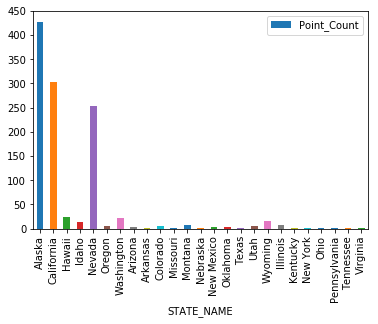

In [29]:
%matplotlib inline
aggregation_df.plot('STATE_NAME','Point_Count', kind='bar')

Clearly, California tops the list with the most number of earthquakes. Let us view what the average intensity and minimum depth is in the plots below:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E46223C3C8>,
      dtype=object)

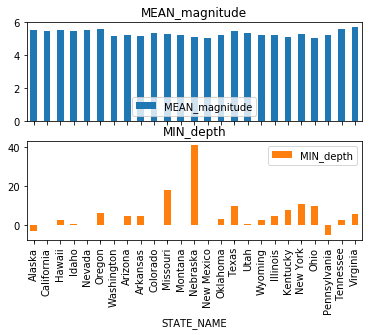

In [30]:
aggregation_df.plot('STATE_NAME',['MEAN_magnitude', 'MIN_depth'],kind='bar', subplots=True)